In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from astropy.table import Table, vstack
import glob

from scipy import stats


In [2]:
import matplotlib.style as style
style.use('seaborn-colorblind')

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize']

[12.0, 8.0]

In [5]:
# Optical efficiencies to be called
OPT_EFF=[0.7, 0.8, 0.9, 1.0]

# size (intensity) outside the ring, to get rid of hadronic showers
size_outside = 500 # phe

# 1. Analyze by yourself MC file

In [6]:
! lstchain_dl1_muon_analysis \
  --input-file ../data/muons/mc/Scale1.0/dl1_muon_0deg_0deg_run1___cta-prod5-lapalma_desert-2158m--dark.h5 \
  -o ../data/muons/mc/Scale1.0/dl1_muon_test_mc.fits --max-muons 10

input files: ../data/muons/mc/Scale1.0/dl1_muon_0deg_0deg_run1___cta-prod5-lapalma_desert-2158m--dark.h5
calib file: None
output file: ../data/muons/mc/Scale1.0/dl1_muon_test_mc.fits
['../data/muons/mc/Scale1.0/dl1_muon_0deg_0deg_run1___cta-prod5-lapalma_desert-2158m--dark.h5']
Opening file ../data/muons/mc/Scale1.0/dl1_muon_0deg_0deg_run1___cta-prod5-lapalma_desert-2158m--dark.h5
Impact parameter=7.876 m, ring_width=0.057 deg, ring radius=1.178 deg, ring completeness=0.733
Number of good muon rings found 1, EventID 100
Impact parameter=0.000 m, ring_width=0.043 deg, ring radius=1.227 deg, ring completeness=0.867
Impact parameter=5.824 m, ring_width=0.049 deg, ring radius=0.956 deg, ring completeness=0.667
Number of good muon rings found 2, EventID 400
Impact parameter=6.345 m, ring_width=0.046 deg, ring radius=1.188 deg, ring completeness=0.933
Number of good muon rings found 3, EventID 500
Impact parameter=5.917 m, ring_width=0.065 deg, ring radius=1.144 deg, ring completeness=0.967


# 2. Compare the optical efficiency of the different runs in the real data folder and plot them together

### Read and fit MC

In [7]:

normalization = 1.1 # deg 
ring_completeness_cut = 0.9
value_at_norm = []

for j, opt_eff in enumerate(OPT_EFF):
    listdir=glob.glob(f'../data/muons/mc/Scale{opt_eff}/dl1*fits')
    dat = Table.read('{}'.format(listdir[0]), format='fits')
    for i in range(1,len(listdir)):
        dat2 = Table.read('{}'.format(listdir[i]), format='fits')
        dat = vstack([dat, dat2])
    df = dat.to_pandas()
    df_good = df[df['good_ring']]

    slope, intercept, r_value, p_value, std_err = stats.linregress(
        (df_good['ring_radius'][(df_good['ring_completeness'] > ring_completeness_cut) 
                                & (df_good['size_outside'] < size_outside)],
         df_good['ring_size'][(df_good['ring_completeness'] > ring_completeness_cut) 
                              & (df_good['size_outside'] < size_outside)]))

    value_at_norm.append(intercept + slope * normalization)
    
slope_opt_eff, intercept_opt_eff, r_value_opt_eff, p_value_opt_eff, std_err_opt_eff = stats.linregress(OPT_EFF, value_at_norm)
    

### Data

In [8]:
runs = np.arange(2965, 2982, 1)

opt_eff_result = []

for i in runs:
    listdir = glob.glob(f'../data/muons/real/20201120/v0.8.3/muons_LST-1.Run0{i}*')

    dat = Table.read('{}'.format(listdir[0]), format='fits')
    for i in range(1,len(listdir)):
        dat2 = Table.read('{}'.format(listdir[i]), format='fits')
        if(len(dat2) == 0):
            continue
        dat = vstack([dat, dat2])

    df = dat.to_pandas()
    df_good_data = df[df['good_ring']]


    slope, intercept, r_value, p_value, std_err = stats.linregress(
        (df_good_data['ring_radius'][(df_good_data['ring_completeness'] > ring_completeness_cut) & (df_good_data['size_outside'] < size_outside)],
         df_good_data['ring_size'][(df_good_data['ring_completeness'] > ring_completeness_cut) & (df_good_data['size_outside'] < size_outside)]))

    phe_normalization = intercept + slope * normalization
    optical_efficiency = (phe_normalization - intercept_opt_eff)/slope_opt_eff * 100

    print(f'Value at radius {normalization} deg {phe_normalization} phe')
    print(f'Optical efficiency {optical_efficiency}')
    
    opt_eff_result.append(optical_efficiency)


Value at radius 1.1 deg 2441.461772705923 phe
Optical efficiency 77.22583253346002
Value at radius 1.1 deg 2456.919048159215 phe
Optical efficiency 77.79894617642888
Value at radius 1.1 deg 2462.2055796520253 phe
Optical efficiency 77.99495635504474
Value at radius 1.1 deg 2447.309563283427 phe
Optical efficiency 77.44265266915079
Value at radius 1.1 deg 2444.4693809392093 phe
Optical efficiency 77.33734644911809
Value at radius 1.1 deg 2456.9135923146755 phe
Optical efficiency 77.79874388858397
Value at radius 1.1 deg 2443.9269262824537 phe
Optical efficiency 77.31723370897717
Value at radius 1.1 deg 2455.010290928135 phe
Optical efficiency 77.72817466086956
Value at radius 1.1 deg 2472.671417154781 phe
Optical efficiency 78.38300108362897
Value at radius 1.1 deg 2446.4634999707982 phe
Optical efficiency 77.41128294757546
Value at radius 1.1 deg 2430.9075483942765 phe
Optical efficiency 76.83451066291201
Value at radius 1.1 deg 2438.0103390349077 phe
Optical efficiency 77.097862780275

### Plot the final results

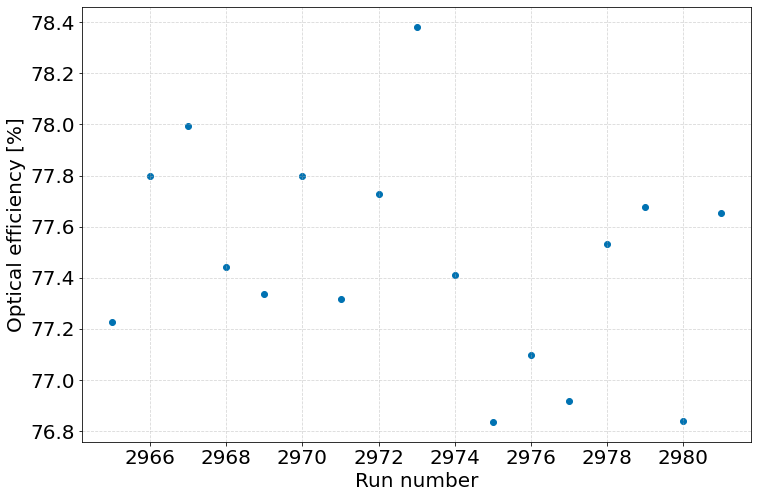

In [9]:
fig, ax = plt.subplots()
ax.scatter(runs, opt_eff_result)
ax.set_xlabel('Run number')
ax.set_ylabel('Optical efficiency [%]')
ax.grid(ls='--', alpha=0.5)